In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import math
import scipy
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

In [2]:
source_image = dm.Utilities.load_greyscale_image("../../data/images/bar_a.png", origin='lower')
target_image = dm.Utilities.load_greyscale_image("../../data/images/bar_b.png", origin='lower')

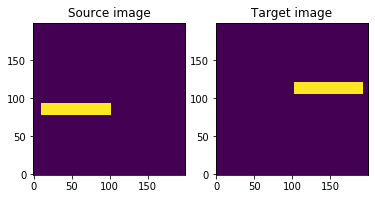

In [3]:
#%matplotlib qt5
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, origin='lower')

plt.show()

In [4]:
sig_smooth = 15
im0 = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
im1 = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))

In [5]:
center = torch.tensor([[100., 100.]])

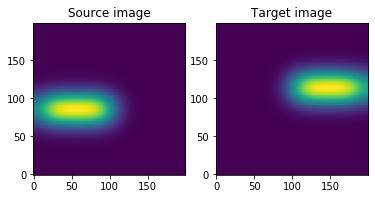

In [6]:
#%matplotlib qt5

plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(im0, origin='lower')
plt.plot(center[0, 0].numpy(), center[0, 1].numpy(), 'x')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(im1, origin='lower')

plt.show()

In [7]:
translation = dm.DeformationModules.ImplicitModule0(2, 1, 200., nu=0.1, gd=center.clone().requires_grad_())

In [8]:
source = dm.Models.DeformableImage(im0.t())
target = dm.Models.DeformableImage(im1.t())

In [9]:
model = dm.Models.RegistrationModel(source, [translation], dm.Attachment.EuclideanPointwiseDistanceAttachment(), fit_gd=[True], lam=100.)

tensor([[100., 100.]], requires_grad=True)


In [10]:
shoot_solver='rk4'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')

In [11]:
fitter.fit(target, 100, costs=costs, options={'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS
Initial cost={'deformation': 0.0, 'attach': 35674.7265625}
Time: 14.967525104999368
Iteration: 0
Costs
deformation=5356.970703125
attach=9259.0615234375
Total cost=14616.0322265625
Time: 22.496501595000154
Iteration: 1
Costs
deformation=5356.978515625
attach=9259.052734375
Total cost=14616.03125
Time: 26.008057961000304
Iteration: 2
Costs
deformation=5356.978515625
attach=9259.052734375
Total cost=14616.03125
Optimisation process exited with message: Convergence achieved.
Final cost=14616.03125
Model evaluation count=44
Time elapsed = 26.008286996002425


In [12]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_image = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0].t()

translation_center = model.init_manifold[1].gd.detach().flatten().tolist()
translation_moment = model.init_manifold[1].cotan.detach().flatten().tolist()
translation_center_end = intermediates['states'][-1][1].gd.flatten().tolist()

print(translation_center)
print(translation_center_end)
print(translation_moment)

[99.9999771118164, 99.99989318847656]
[194.35496520996094, 128.87196350097656]
[0.0030486953910440207, 0.0009328208980150521]


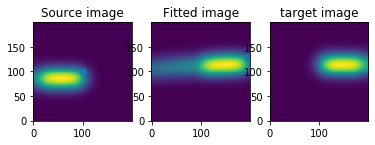

In [17]:
#%matplotlib qt5
plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(im0, origin='lower')
plt.plot(center.flatten().tolist()[0], center.flatten().tolist()[1], 'X')
plt.quiver(translation_center[0], translation_center[1],
           translation_moment[0], translation_moment[1])

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image, origin='lower')
#plt.plot(translation_center[0], translation_center[1], 'X')
plt.plot(translation_center_end[0], translation_center_end[1], 'X')

plt.subplot(1, 3, 3)
plt.title("target image")
plt.imshow(im1, origin='lower')

plt.show()